In [1]:
import json
import matplotlib.pyplot as plt
import keras
import keras.layers as layers
from GHCND import *

2023-03-22 10:35:34.186176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 10:35:34.368659: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-22 10:35:34.376373: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 10:35:34.376412: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
f = open('data/stat_counts_tmax.json')
counts_tmax = json.load(f)
f = open('data/stat_counts_prcp.json')
counts_prcp = json.load(f)

# find all stations with no data gaps
no_gaps_tmax = [name for name, count in counts_tmax.items() if count <= 100]
print(f"Number of tmax stations found: {len(no_gaps_tmax)}")
no_gaps_prcp = [name for name, count in counts_prcp.items() if count <= 100]
print(f"Number of prcp stations found: {len(no_gaps_prcp)}")


Number of stations found: 103
['ASN00003003', 'ASN00005007', 'ASN00009789', 'ASN00010286', 'ASN00013017', 'ASN00015135', 'ASN00015590', 'ASN00027045', 'ASN00030124', 'ASN00033119', 'ASN00048027', 'ASN00056242', 'ASN00060141', 'ASN00072150', 'ASN00074258', 'ASN00076031', 'ASN00085072', 'ASN00091293', 'CA001096631', 'CA002202402', 'CA002202578', 'CA002300904', 'CA002301153', 'CA003066002', 'CA007047914', 'CA008501900', 'DA000030380', 'EG000624200', 'FI000002401', 'FMW00040308', 'FMW00040504', 'FR000007130', 'FR000007255', 'FR000007630', 'GM000010147', 'GM000010393', 'GM000010962', 'GQW00041415', 'JA000047927', 'JA000047945', 'NLM00006260', 'NO000001026', 'NO000001465', 'NO000011520', 'NOM00001238', 'PP000092035', 'RMW00040604', 'RQW00011641', 'RSM00024738', 'SHM00061901', 'SP000008202', 'SV000001008', 'SWE00140178', 'SWE00140622', 'SWM00002589', 'USW00003870', 'USW00012842', 'USW00012916', 'USW00012921', 'USW00013722', 'USW00013743', 'USW00013865', 'USW00013880', 'USW00013882', 'USW00013

### Get data, and shape train, validate and test arrays

In [3]:
# create instance of the GHCND class and extract information on countries and stations from their respective files
ghn = GHCND()
ghn.readCountriesFile()
ghn.readStationsFile()

# get list of station names
station_names = ghn.getStatKeyNames()

# set station to be investigated
# stations that give nice results:
# -1; 50
station = no_gaps_tmax[-1]
print(f"Station selected: {station}")

# get url for a given station index
fileName = f"{station}.dly"
print(f"Filename: {fileName}")
urlName = f"http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/{fileName}"
print(f"url name: {urlName}")

# copy station data from remote to local
destination = f"data/{fileName}"
print(f"destination: {destination}")
urllib.request.urlretrieve(urlName, destination)
station_data = ghn.processFile(destination)
print(f"Station details: {ghn.getStation(station)}")

# extract data for specified variable into an instance of the Variable class
t_max = Variable(ghn.getVar(station_data, 'TMAX'), "max temp (degC)", ghn.stationDict[station].name)
t_max.convert_time()
dates = t_max.get_dates()
vals = t_max.get_vals()


Read 219 countries and codes
Read 991 stations from the GSN
Station selected: ZI000067964
Filename: ZI000067964.dly
url name: http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/ZI000067964.dly
destination: data/ZI000067964.dly
Station details: ZI000067964 is BULAWAYO (GOETZ OBS, Zimbabwe at -20.15 28.617 1344.0


Text(0, 0.5, 'Normalised mean monthly maximum temperature')

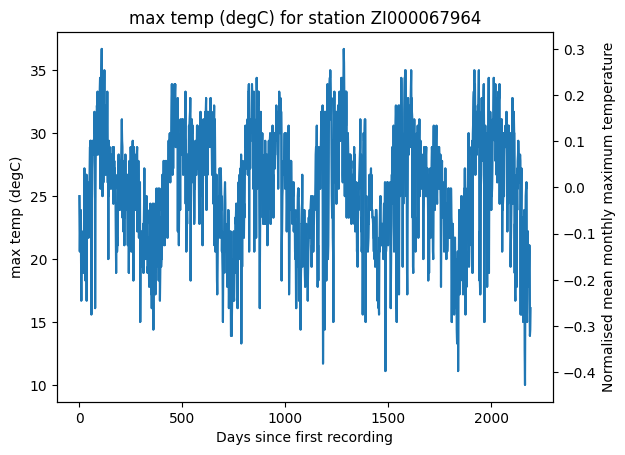

In [4]:
# normalise data
vals_normalised = t_max.normalise(vals)

# plot means and normalised means
fig, ax = plt.subplots()
ax.plot(vals)
ax.set_xlabel("Days since first recording")
ax.set_ylabel(f"{t_max.get_label()}")
ax.set_title(f"{t_max.get_label()} for station {station}")
ax2 = ax.twinx()
ax2.plot(vals_normalised)
ax2.set_ylabel("Normalised mean monthly maximum temperature")


In [5]:
WINDOW_SIZE = 10
OFFSET = 1

# calculate appropriate divisions of data
test_len = int(len(vals_normalised) * 0.2)
train_len = int(len(vals_normalised) * 0.7)
validate_len = int(len(vals_normalised) * 0.1)

print(f"Length of training data: {train_len}")
print(f"Length of validation data: {validate_len}")
print(f"Length of testing data: {test_len}")

# divide data into training, validating and testing sets
vals_test = vals_normalised[:test_len]
vals_train = vals_normalised[test_len+1:test_len+train_len]
vals_validate = vals_normalised[test_len+train_len+1:]

# split data into input windows and targets
input_test, target_test = shapeArray(vals_test, WINDOW_SIZE, OFFSET)
input_train, target_train = shapeArray(vals_train, WINDOW_SIZE, OFFSET)
input_validate, target_validate = shapeArray(vals_validate, WINDOW_SIZE, OFFSET)

# reshape the data into the correct format for input into the model
n_features = 1
print(f"Training input shape before reshaping: {np.shape(input_train)}")
input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
print(f"Training input shape after reshaping: {np.shape(input_train)}")


Length of training data: 1533
Length of validation data: 219
Length of testing data: 438
Training input shape before reshaping: (1522, 10)
Training input shape after reshaping: (1522, 10, 1)


2023-03-22 10:35:38.989659: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 10:35:38.989698: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 10:35:38.989717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-03-22 10:35:38.989968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 1s 9ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 2/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 3/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 5/100
48/48 [==============================] -

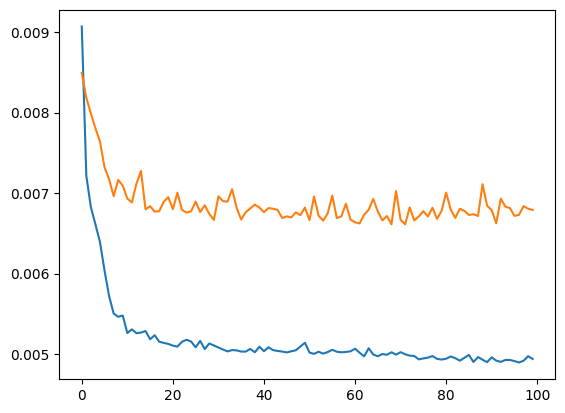

In [6]:
model = keras.models.Sequential()
model.add(layers.LSTM(64, input_shape = (None, 1), activation = 'relu', return_sequences = False))
model.add(layers.Dense(1, activation = "linear"))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

model.summary()

# train model and extract final loss
history = model.fit(input_train, target_train, epochs = 100, validation_data = (input_validate, target_validate))
cost = history.history['loss']
val_cost = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(cost)
ax.plot(val_cost)

14/14 [==============================] - 0s 2ms/step


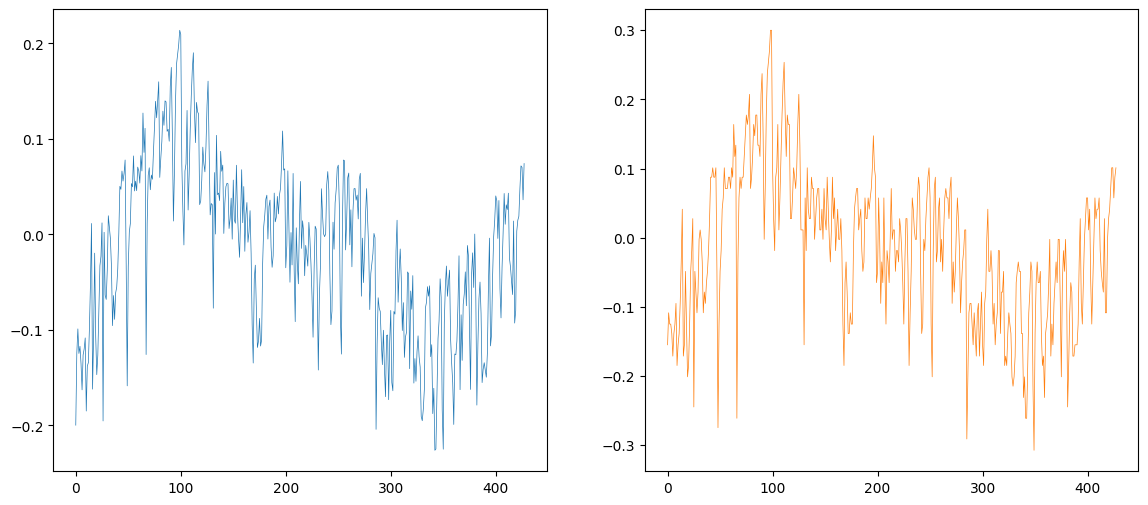

In [7]:
prediction = model.predict(input_test)

fig, ax = plt.subplots(1,2, figsize = (14, 6))
ax[0].plot(prediction, color = 'tab:blue', linewidth = 0.5)
ax[1].plot(target_test, color = 'tab:orange', linewidth = 0.5)


At first glance, these appear to be very similar. Compare the first three months in more detail:

In [8]:
print(target_test[:10])
shifted_vals = shift(target_test)
print(shifted_vals[:10])

[-0.15504224 -0.10872071 -0.12506949 -0.12506949 -0.13869347 -0.17139101
 -0.13869347 -0.12506949 -0.09509674 -0.18501499]
[-0.15504224 -0.15504224 -0.10872071 -0.12506949 -0.12506949 -0.13869347
 -0.17139101 -0.13869347 -0.12506949 -0.09509674]


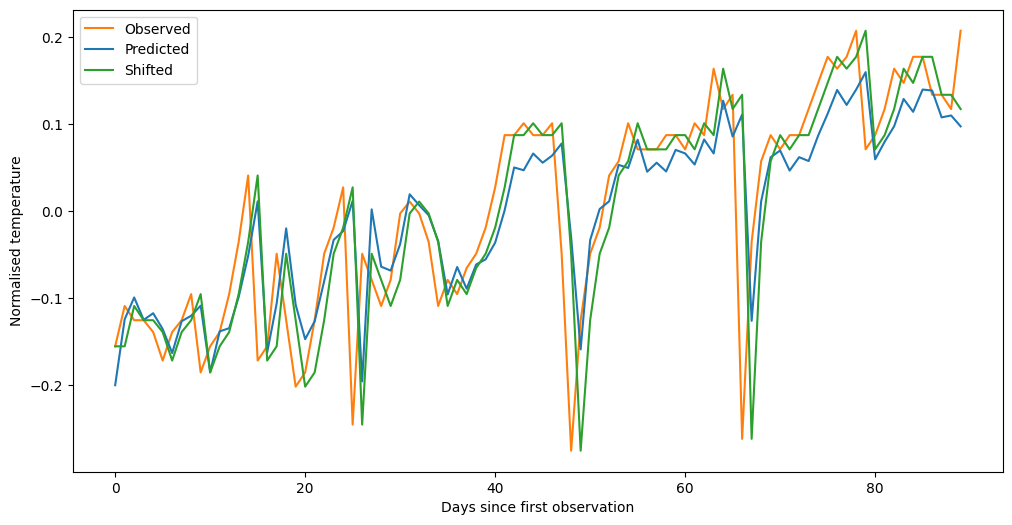

In [9]:
months_to_plot = 3

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(target_test[:months_to_plot*30], label = "Observed", color = 'tab:orange')
ax.plot(prediction[:months_to_plot*30], label = "Predicted", color = 'tab:blue')
ax.plot(shifted_vals[:months_to_plot*30], label = "Shifted", color = 'tab:green')
ax.set_xlabel("Days since first observation")
ax.set_ylabel("Normalised temperature")
ax.legend()


### Least mean-squared

Sum of the squared errors.

In [10]:
fake_mse = weather_fake_mse(vals)
print(fake_mse)


8.056015518028241


## Vary the offset

In [21]:
WINDOW_SIZE = 10
offsets = np.linspace(1, 301, 31)
costs = []
val_costs = []

for offset in offsets:
    offset = int(offset)
    # calculate appropriate divisions of data
    test_len = int(len(vals_normalised) * 0.2)
    train_len = int(len(vals_normalised) * 0.7)
    validate_len = int(len(vals_normalised) * 0.1)

    #print(f"Length of training data: {train_len}")
    #print(f"Length of validation data: {validate_len}")
    #print(f"Length of testing data: {test_len}")

    # divide data into training, validating and testing sets
    vals_test = vals_normalised[:test_len]
    vals_train = vals_normalised[test_len+1:test_len+train_len]
    vals_validate = vals_normalised[test_len+train_len+1:]

    # split data into input windows and targets
    input_test, target_test = shapeArray(vals_test, WINDOW_SIZE, offset)
    input_train, target_train = shapeArray(vals_train, WINDOW_SIZE, offset)
    input_validate, target_validate = shapeArray(vals_validate, WINDOW_SIZE, offset)

    # reshape the data into the correct format for input into the model
    n_features = 1
    #print(f"Training input shape before reshaping: {np.shape(input_train)}")
    input_train = input_train.reshape((input_train.shape[0], input_train.shape[1], n_features))
    input_test = input_test.reshape((input_test.shape[0], input_test.shape[1], n_features))
    input_validate = input_validate.reshape((input_validate.shape[0], input_validate.shape[1], n_features))
    #print(f"Training input shape after reshaping: {np.shape(input_train)}")

    model = keras.models.Sequential()
    model.add(layers.LSTM(64, input_shape = (None, 1), activation = 'relu', return_sequences = False))
    model.add(layers.Dense(1, activation = "linear"))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')

    #model.summary()

    # train model and extract final loss
    history = model.fit(input_train, target_train, epochs = 80, validation_data = (input_validate, target_validate))
    costs.append(history.history['loss'][-1])
    val_costs.append(history.history['val_loss'][-1])

fig, ax = plt.subplots()
ax.plot(offsets, costs)
ax.plot(offsets, val_costs)


Epoch 1/80
48/48 [==============================] - 1s 8ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 2/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 3/80
48/48 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0081
Epoch 4/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 5/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 6/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 7/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0058 - val_loss: 0.0073
Epoch 8/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0074
Epoch 9/80
48/48 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 10/80
48/48 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0069
Epoch 11/80
48/48 [

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

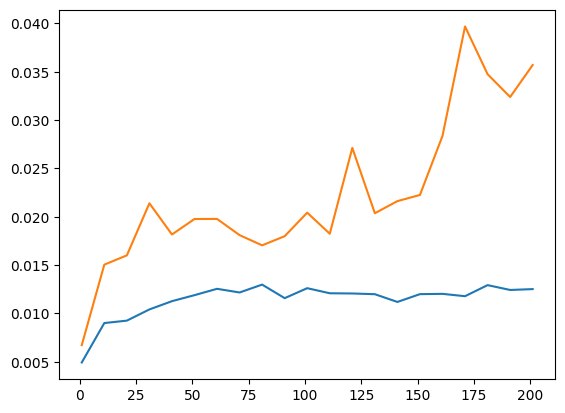

In [24]:
fig, ax = plt.subplots()
ax.plot(offsets[:len(costs)], costs)
ax.plot(offsets[:len(val_costs)], val_costs)